# English STELLA Transcriptions Dataset

The STELLA dataset...



# Data preparation

Format Dataset into the wanted architecture. This procedure extracts audiobook transcriptions from the original dataset and sorts them into the same splits as the audio files.

```
txt
├── LANG
│   ├── HOUR_SPLIT
│   │   ├── SECTION_SPLIT
│   │   │   ├── books.txt
│   │   │   ├── meta.json
│   │   │   └── transcription.txt
│   │   ├── ...
│   ├── ...
│   ...

```
- txt : folder containing transcriptions
- LANG: corresponds to the given language
- HOUR_SPLIR: corresponds to the size of the section splits in number of hours of speech,
              formatted as (50h, 100h, ..., 3200h)
- SECTION_SPLIT: separation of content into sections with equal amount of speech content.
- books.txt: the list of books used for this split
- meta.json: metadata generated during clean-up used to measure effectiveness of cleaning.
- transcript.txt: the agregated transcripts of the audiobooks in the list.

In [1]:
from lexical_benchmark.datasets.machine import stella
from lexical_benchmark.utils import timed_status

prep = stella.STELAPrepTranscripts(lang="EN")
with timed_status(status="Preping stela transcriptions...", complete_status="Succesfuly build STELA Transcript dataset !"):
    prep.build_transcript()

Output()

Succesfuly build STELA Transcript dataset ! (Total time: 2 minutes and 11 seconds)

## Data Cleaning

Clean-up text to keep only clean words that can be piped through the dictionairy.

RULES (Order Matters):
1) Illustration tag removal
2) URL removal
3) TextNormalisation : correct accents & remove non-printable characters
4) Trancribe numbers
5) Remove roman numerals
6) Fix symbols ($,€, etc..)
7) AZFilter

    * replace '-' with a space to extract hyphenated words (fifty-five -> fifty five)

    * Keeps apostrophe char(*'*) to protect shorthands (ex: ain't)
  
    * purges everything not between [A-Z].

    * lowecases everything
8) Fix words by removing prefix and trailing quote char (')

In [2]:
from lexical_benchmark.datasets.machine import stella
from lexical_benchmark.utils import timed_status

cleaner = stella.StelaCleaner()
with timed_status(status="Cleaning STELA Transcripts", complete_status="Succesfuly cleanned up STELA Transcript dataset !"):
    cleaner.cleanup_raw(compute_word_freqs=True)

Output()

Succesfuly cleanned up STELA Transcript dataset ! (Total time: 1 hour, 21 minutes and 30 seconds)

# Word Filtering

Using a pre-selected lexicon we filter the corpus to separated known from unknown words

In [1]:
from lexical_benchmark.datasets.machine import stella
from lexical_benchmark.datasets import utils
from lexical_benchmark.utils import timed_status

dataset_cleaner = stella.StelaCleaner()

with timed_status(status="Word Filtering", complete_status="Succesfuly completed word filtering !"):
    dataset_cleaner.mk_clean(
        word_cleaners={"EN": utils.DictionairyCleaner(lang="EN")},
        compute_word_freqs=True,
    )

Output()

Succesfuly completed word filtering ! (Total time: 2 minutes and 35 seconds)

## Computing cleanup stats

In [6]:
from lexical_benchmark.datasets.machine import stella
from lexical_benchmark.utils import timed_status
from pathlib import Path
# ------------------
DEBUG = True
SAVE_CSVs = True
PRINT = True
# ------------------
# Configure inputs
clean_dataset = stella.STELLADatasetClean()
raw_dataset = stella.STELLADatasetRaw()
meta_root = Path("stela_wf") if DEBUG else clean_dataset.wf_meta_dir
(meta_root / "raw").mkdir(exist_ok=True, parents=True)
(meta_root / "clean").mkdir(exist_ok=True, parents=True)
(meta_root / "bad").mkdir(exist_ok=True, parents=True)

stats_dict = {}

with timed_status(status="Extracting Stats...", complete_status="Succesfuly extracted statistics !"):
    for lang, hour_split in clean_dataset.iter_hour_splits('EN'):
        clean_stats = clean_dataset.word_stats_by_split(lang, hour_split)
        raw_stats = raw_dataset.word_stats_by_split(lang, hour_split)

        stats_dict[f"{lang}-{hour_split}"] = {
            "raw": raw_stats,
            "clean": clean_stats
        }

        # Save Files
        if SAVE_CSVs:
            raw_stats.freq_map.to_csv(meta_root / f"raw/{lang}_{hour_split}.word-freq.csv", index=False)
            clean_stats["good"].freq_map.to_csv(meta_root / f"clean/{lang}_{hour_split}.word-freq.csv", index=False)
            clean_stats["bad"].freq_map.to_csv(meta_root / f"bad/{lang}_{hour_split}.word-freq.csv", index=False)


# Print resuts
if PRINT:
    for key, value in stats_dict.items():
        print("-" * 10)
        print(f"==> {key}")
        # ALL
        print(f"RAW:: > Number of tokens : {value['raw'].token_nb:_}, Number of types : {value['raw'].type_nb:_}")

        # Clean
        print(f"CLEAN:: > Number of tokens : {value['clean']['good'].token_nb:_}, Number of types : {value['clean']['good'].type_nb:_}")

        # Rejected
        print(f"REJECT:: > Number of tokens : {value['clean']['bad'].token_nb:_}, Number of types : {value['clean']['bad'].type_nb:_}")

        print("-" * 10)

Output()

Succesfuly extracted statistics ! (Total time: 18 seconds)

----------
==> EN-100h
RAW:: > Number of tokens : 42_030_077, Number of types : 336_023
CLEAN:: > Number of tokens : 41_394_999, Number of types : 132_199
REJECT:: > Number of tokens : 635_078, Number of types : 203_824
----------
----------
==> EN-1600h
RAW:: > Number of tokens : 42_030_077, Number of types : 336_023
CLEAN:: > Number of tokens : 41_394_999, Number of types : 132_199
REJECT:: > Number of tokens : 635_078, Number of types : 203_824
----------
----------
==> EN-200h
RAW:: > Number of tokens : 41_928_401, Number of types : 335_905
CLEAN:: > Number of tokens : 41_293_444, Number of types : 132_128
REJECT:: > Number of tokens : 634_957, Number of types : 203_777
----------
----------
==> EN-3200h
RAW:: > Number of tokens : 42_030_077, Number of types : 336_023
CLEAN:: > Number of tokens : 41_394_999, Number of types : 132_199
REJECT:: > Number of tokens : 635_078, Number of types : 203_824
----------
----------
==> EN-400h
RAW:: > Number of tokens : 42_030_077, Number of ty

In [ ]:
""" Test Lexicon"""
from lexical_benchmark.datasets import utils
from lexical_benchmark.datasets.utils import lexicon

en_cleaner = utils.DictionairyCleaner(lang="EN")
lexique = lexicon.Lexicon(lang="EN")

"potato" in lexique.words, "frezdo" in lexique.words

### Computing Block Averaging

To calculate word rejection rate in the dataset, we use the method of 
cutting each split into chunk of a specific size (16k tokens per chunk), and then proceed to calculate 
the rejection rate.

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

from lexical_benchmark.datasets.utils import lexicon
from lexical_benchmark.datasets.machine import stella
from lexical_benchmark.utils import timed_status



def split_and_fill_chunks(word_list: list[str], chunk_size: int = 16_000):
    """Evenly spread words in the given list into chunks of given size.

    If the last chunk is not of equal size with the rest, randomly duplicate words
    until all have the exact same size.
    """

    # Step 0: Shuffle words as to avoid having proximity bias
    random.shuffle(word_list)
    # Step 1: Split the list into chunks of chunk_size
    chunks = [word_list[i:i + chunk_size] for i in range(0, len(word_list), chunk_size)]

    # Step 2: Ensure each chunk has exactly chunk_size words
    for i in range(len(chunks)):
        if len(chunks[i]) < chunk_size:
            # Calculate the deficit
            deficit = chunk_size - len(chunks[i])
            # Select words randomly from word_list
            words_to_add = random.choices(word_list, k=deficit)

            # Add the selected words to the current chunk
            chunks[i].extend(words_to_add)

    return chunks



def calculate_rejection_rates(chunk_list, lexicon: lexicon.Lexicon,):
    rejection_rates = []

    for chunk in chunk_list:
        total_tokens = len(chunk)  # Total tokens (words)
        total_token_types = len(set(chunk))  # Unique token types

        # Check which tokens are valid
        invalid_tokens = 0
        invalid_token_types = set()  # To track invalid token types

        for token in chunk:
            if not lexicon(token):
                invalid_tokens += 1  # Count invalid tokens
                invalid_token_types.add(token)  # Add to invalid token types set

        # Calculate rejection rates
        token_rejection_rate = (invalid_tokens / total_tokens) * 100
        token_type_rejection_rate = (len(invalid_token_types) / total_token_types) * 100

        # Store rejection rates for the chunk
        rejection_rates.append({
            'chunk': chunk,
            'token_rejection_rate': token_rejection_rate,
            'token_type_rejection_rate': token_type_rejection_rate
        })

    return rejection_rates, total_tokens, total_token_types


def plot_rejection_rate_trends(rejection_rates, set_label):
    chunks = np.arange(len(rejection_rates)) + 1  # Chunk numbers
    token_rejection_rates = [rate['token_rejection_rate'] for rate in rejection_rates]
    token_type_rejection_rates = [rate['token_type_rejection_rate'] for rate in rejection_rates]

    plt.plot(chunks, token_rejection_rates, label='Token Rejection Rate', marker='o')
    plt.plot(chunks, token_type_rejection_rates, label='Token Type Rejection Rate', marker='o')

    plt.xlabel('Chunks')
    plt.ylabel('Rejection Rate (%)')
    plt.title(f'Rejection Rate Trends Across Chunks ({set_label})')
    plt.legend()
    plt.grid(True)
    plt.show()


def calculate_avg_and_median_rejection_rates(rejection_rates):
    # Extract token and token type rejection rates into lists
    token_rejection_rates = [rate['token_rejection_rate'] for rate in rejection_rates]
    token_type_rejection_rates = [rate['token_type_rejection_rate'] for rate in rejection_rates]

    # Calculate averages
    avg_token_rejection_rate = np.mean(token_rejection_rates)
    avg_token_type_rejection_rate = np.mean(token_type_rejection_rates)

    # Calculate medians
    median_token_rejection_rate = np.median(token_rejection_rates)
    median_token_type_rejection_rate = np.median(token_type_rejection_rates)

    return {
        'avg_token_rejection_rate': avg_token_rejection_rate,
        'avg_token_type_rejection_rate': avg_token_type_rejection_rate,
        'median_token_rejection_rate': median_token_rejection_rate,
        'median_token_type_rejection_rate': median_token_type_rejection_rate
    }


#### Computation of rejection rates

In [2]:
rejection_rates = {}
raw_dataset = stella.STELLADatasetRaw()
with timed_status(status="Calculating Rejection Rates of StellaRaw ...", complete_status="Completed !"):
    for lang in raw_dataset.get_languages():
        lexique = lexicon.Lexicon(lang=lang)
        for _, split in raw_dataset.iter_hour_splits(lang):
            word_list = raw_dataset.get_all_raw_words_from_split(language=lang, hour_split=split)
            word_chunk_list = split_and_fill_chunks(word_list, chunk_size=16_000)
            rj_rate, token_count, type_count = calculate_rejection_rates(word_chunk_list, lexique)
            rejection_rates[f"{lang}_{split}"] = {
                "rates": rj_rate,
                "token_count": token_count,
                "type_count": type_count
            }

Output()

Completed ! (Total time: 12 minutes and 54 seconds)

#### Computation of Averages

In [3]:
with timed_status(status="Computing Averages ...", complete_status="Completed !"):
    for lang in raw_dataset.get_languages():
        for _, split in raw_dataset.iter_hour_splits(lang):
            rejection_rates[f"{lang}_{split}"]["avg"] = calculate_avg_and_median_rejection_rates(
                rejection_rates[f"{lang}_{split}"]["rates"]
            )

Output()

Completed ! (Total time: 1 seconds)

##### Print Results

In [4]:
for lang in raw_dataset.get_languages():
    for _, split in raw_dataset.iter_hour_splits(lang):
        print(f"{'-'*5}{f'{lang}_{split}'}{'-'*5}")
        total_tokens = rejection_rates[f"{lang}_{split}"]['token_count']
        total_types = rejection_rates[f"{lang}_{split}"]['type_count']
        avgs = rejection_rates[f"{lang}_{split}"]['avg']
        print(f"""
Raw has {total_tokens:_} tokens,
with {total_types:_} types.
Split word-list into {len(word_chunk_list)} chunks of 16k tokens.
----
The average token rejection rate is {avgs['avg_token_rejection_rate']/100:.4%}.
The average token type rejection rate is {avgs['avg_token_type_rejection_rate']/100:.4%}.

Median token rejection rate {avgs['median_token_rejection_rate']/100:.4%}.
Median token type rejection rate {avgs['median_token_type_rejection_rate']/100:.4%}.
""")

-----EN_100h-----

Raw has 16_000 tokens,
with 5_888 types.
Split word-list into 2586 chunks of 16k tokens.
----
The average token rejection rate is 17.6487%.
The average token type rejection rate is 40.1868%.

Median token rejection rate 17.6500%.
Median token type rejection rate 40.1856%.

-----EN_1600h-----

Raw has 16_000 tokens,
with 5_848 types.
Split word-list into 2586 chunks of 16k tokens.
----
The average token rejection rate is 17.6488%.
The average token type rejection rate is 40.1885%.

Median token rejection rate 17.6438%.
Median token type rejection rate 40.1786%.

-----EN_200h-----

Raw has 16_000 tokens,
with 5_890 types.
Split word-list into 2586 chunks of 16k tokens.
----
The average token rejection rate is 17.6482%.
The average token type rejection rate is 40.1962%.

Median token rejection rate 17.6438%.
Median token type rejection rate 40.1940%.

-----EN_3200h-----

Raw has 16_000 tokens,
with 5_747 types.
Split word-list into 2586 chunks of 16k tokens.
----
The av

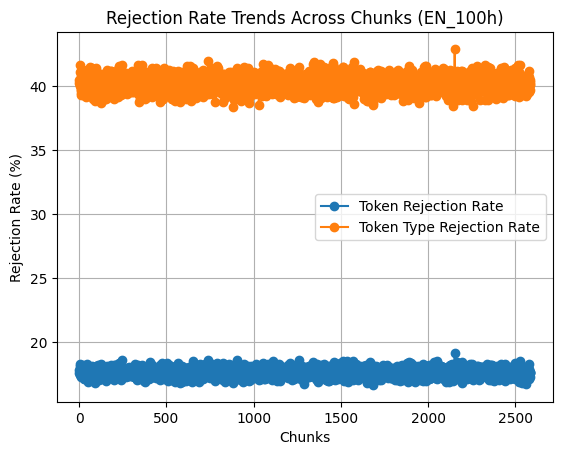

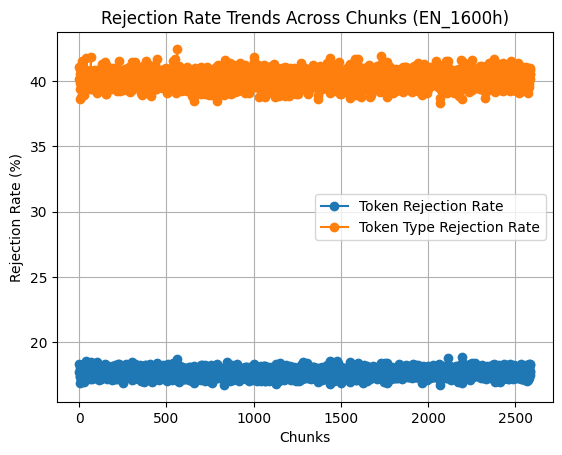

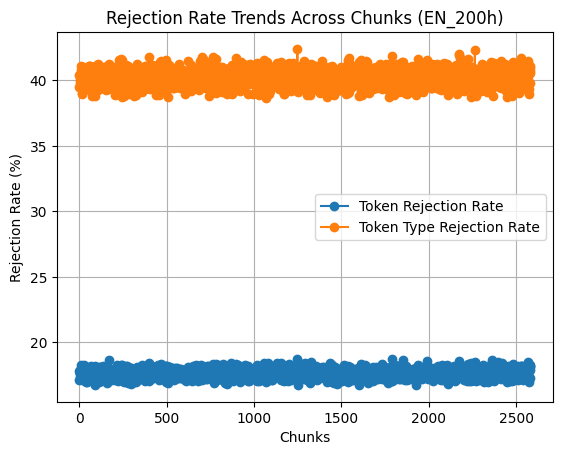

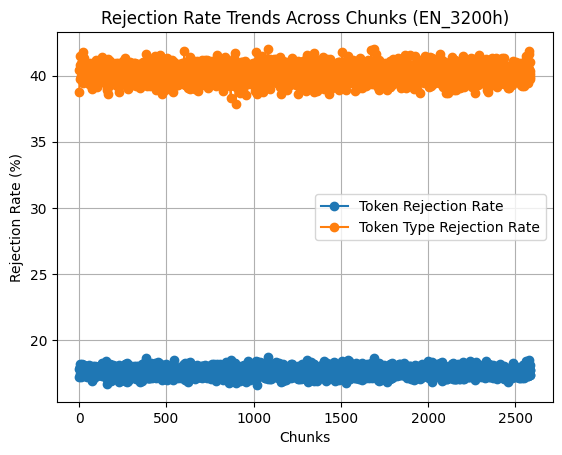

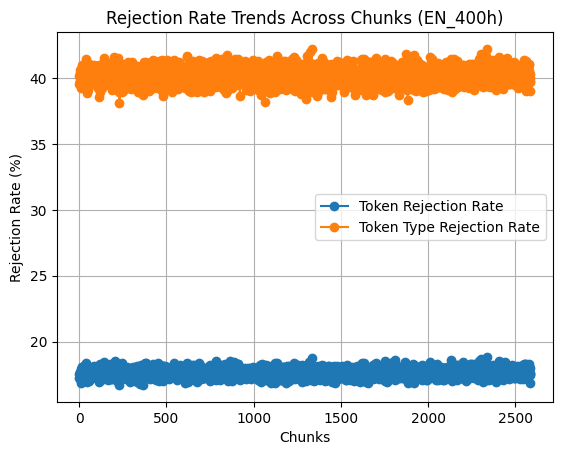

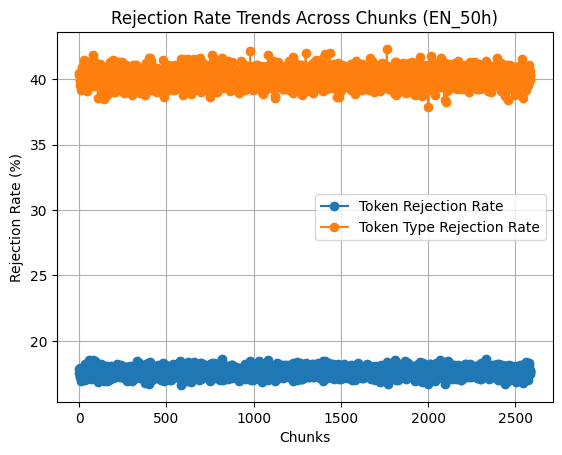

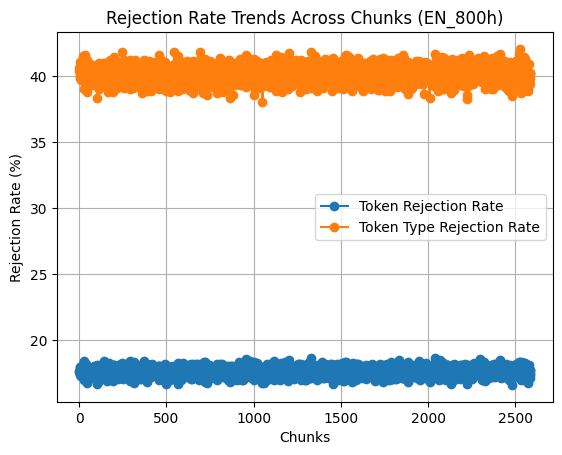

In [7]:
# Plot Rejection Rates
for lang in raw_dataset.get_languages():
    for _, split in raw_dataset.iter_hour_splits(lang):
        plot_rejection_rate_trends(rejection_rates[f"{lang}_{split}"]["rates"], f"{lang}_{split}")